<a href="https://colab.research.google.com/github/saffarizadeh/INSY5378/blob/main/Classification_and_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://kambizsaffari.com/Logo/College_of_Business.cmyk-hz-lg.png" width="500px"/>

# *INSY 5378 - Advanced AI*

# **Classification and Regression**

Instructor: Dr. Kambiz Saffari

---

Note: You MUST read the chapter. Going through this notebook does not replace the value of reading the chapter.

Link to the chapter: https://deeplearningwithpython.io/chapters/chapter04_classification-and-regression/

> *Disclaimer: This notebook is a personal study guide created for educational purposes. It summarizes and references material from "Deep Learning with Python, Third Edition" by François Chollet and Matthew Watson (Manning Publications). All rights to the original content, including text, images, and code, belong to the respective authors and publisher. This notebook is not intended for commercial use or redistribution. Please support the authors by purchasing the book at Manning.*

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

## Classification and regression

This chapter covers your first examples of real-world machine learning workflows. You'll work through the three most common use cases of neural networks:

- **Binary classification** - classifying movie reviews as positive or negative (IMDb)
- **Multiclass classification** - classifying newswires by topic (Reuters)
- **Scalar regression** - estimating house prices (California Housing)

These examples will introduce you to data preprocessing, basic model-architecture principles, and model evaluation. By the end of this chapter you'll be able to use neural networks to handle simple classification and regression tasks over vector data.

---

**Key terminology (Classification & Regression Glossary)**

| Term | Definition |
|------|------------|
| Sample / Input | One data point that goes into your model |
| Prediction / Output | What comes out of your model |
| Target | The ground-truth value your model should ideally predict |
| Loss value | A measure of the distance between prediction and target |
| Classes | The set of possible labels in a classification problem |
| Binary classification | Categorising each input into one of two exclusive classes |
| Multiclass classification | Categorising each input into more than two classes |
| Multilabel classification | Each input can be assigned *multiple* labels |
| Scalar regression | Predicting a single continuous value |
| Vector regression | Predicting a set of continuous values (e.g. bounding-box coordinates) |
| Mini-batch | A small set of samples (typically 8–128) processed simultaneously |

### Classifying movie reviews: A binary classification example

Two-class (binary) classification is one of the most common ML problems. Here you'll classify movie reviews as **positive** or **negative** based on their text content, using the IMDb dataset.

#### The IMDb dataset

The IMDb dataset contains 50,000 highly polarised movie reviews from the Internet Movie Database, split evenly into 25,000 for training and 25,000 for testing (50% negative, 50% positive each).

The dataset comes pre-packaged with Keras and is already preprocessed: each review is a sequence of integers where each integer encodes a specific word in a dictionary. The `num_words=10000` argument keeps only the 10,000 most frequent words, discarding rare words. Without this limit you'd have 88,585 unique words — many appearing in only a single sample and thus not useful for classification.

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000
)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Each review is stored as a list of word indices (integers encoding a sequence of words). `train_labels` and `test_labels` are arrays of 0s and 1s, where **0 = negative** and **1 = positive**.

In [4]:
train_labels[0]

np.int64(1)

In [5]:
max([max(sequence) for sequence in train_data])

9999

Because we restricted to the top 10,000 most frequent words, no word index exceeds 9,999.

In [6]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The indices are offset by 3 because indices 0, 1, and 2 are reserved for **"padding,"** **"start of sequence,"** and **"unknown"** respectively. These reserved indices have no entry in the word dictionary, so `dict.get(i - 3, "?")` falls back to the default `"?"` string. The `"?"` is just an arbitrary placeholder for display; you could use any string. This entire decoding step is purely for human inspection; the model only ever sees the integer sequences (and later, their multi-hot encoded form).

> Note: The IMDB dictionary contains only real words (starting at index 1). The values 0, 1, and 2 are reserved in the encoded reviews for padding, start of sequence, and unknown tokens, so they do not appear in reverse_word_index. During decoding, we subtract 3 from each index: for i < 3, i - 3 is negative and not found in the dictionary (displayed as "?"), while for i ≥ 3, i - 3 correctly maps to a real word.

In [7]:
decoded_review[:100]

"? this film was just brilliant casting location scenery story direction everyone's really suited the"

#### Preparing the data

You can't feed lists of integers of varying lengths directly into a neural network; it expects contiguous batches of uniform shape. There are two common approaches:

1. **Pad** the lists to the same length, creating an integer tensor of shape `(samples, max_length)`, then use an `Embedding` layer (covered later in the book).
2. **Multi-hot encode** the lists into vectors of 0s and 1s, where each dimension indicates whether a given word is present. E.g., the sequence `[8, 5]` becomes a 10,000-dimensional vector that is all zeros except at indices 5 and 8.

We'll use multi-hot encoding here.

In [8]:
import numpy as np

def multi_hot_encode(sequences, num_tokens):
    # All-zero matrix: one row per sample, one column per possible word
    results = np.zeros((len(sequences), num_tokens))
    for i, sequence in enumerate(sequences):
        # sequence is e.g. [1, 14, 22, 43, ...] - NumPy advanced indexing
        # sets all those positions to 1.0 in one go
        results[i][sequence] = 1.0
    return results

x_train = multi_hot_encode(train_data, num_tokens=10000)
x_test = multi_hot_encode(test_data, num_tokens=10000)

Each sample is now a 10,000-dimensional binary vector. We also cast the labels from ints to `float32` so they're compatible with the model's floating-point computations.

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [10]:
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

#### Building your model

Since the input is vectors and the labels are scalars (0 or 1), a plain stack of `Dense` layers with `relu` activations works well. Two key architecture decisions:

- **How many layers** to use
- **How many units** per layer

We'll use two intermediate layers with **16 units each**, plus a final output layer with **1 unit** and a **sigmoid** activation (outputting a probability between 0 and 1).

Each `Dense` layer with `relu` computes: `output = relu(input @ W + b)`. Having 16 units means the weight matrix `W` has shape `(input_dimension, 16)`, projecting the input into a 16-dimensional representation space. More units = more expressive power, but also more computational cost and higher risk of overfitting.

**Why activation functions?** Without a non-linearity like `relu`, a `Dense` layer performs only a linear transformation (`input @ W + b`). A deep stack of linear layers is still just a single linear operation. Non-linear activations give the network access to a much richer set of learned representations.

**Why sigmoid for the output?** It squashes arbitrary values into `[0, 1]`, so the output can be interpreted as the probability that a review is positive.

In [11]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [12]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

**Loss function - `binary_crossentropy`:** Because this is a binary classification problem with a sigmoid output (i.e., the model outputs a probability), `binary_crossentropy` is the natural choice. It measures the distance between the predicted probability distribution and the ground-truth distribution. You *could* use `mean_squared_error`, but crossentropy is generally best for probability outputs.

**Optimizer - `adam`:** A reliable default for virtually any problem.

#### Validating your approach

A deep learning model should never be evaluated on its training data. We create a **validation set** of 10,000 samples from the training data to monitor accuracy during training.

**Why not just use the test set?** Because you'll use validation results to make tuning decisions (model size, number of epochs, etc.). Once you start optimising for validation performance, those scores no longer reflect true generalisation. The test set must remain untouched until final evaluation.

In [13]:
# To shuffle the dataset
# from sklearn.utils import shuffle
# x_train, y_train = shuffle(x_train, y_train)

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [14]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6032 - loss: 0.6414 - val_accuracy: 0.8539 - val_loss: 0.4411
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8912 - loss: 0.3611 - val_accuracy: 0.8851 - val_loss: 0.3118
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9346 - loss: 0.2218 - val_accuracy: 0.8885 - val_loss: 0.2838
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9515 - loss: 0.1668 - val_accuracy: 0.8879 - val_loss: 0.2803
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9701 - loss: 0.1220 - val_accuracy: 0.8851 - val_loss: 0.2976
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9767 - loss: 0.1004 - val_accuracy: 0.8830 - val_loss: 0.3051
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9849 - loss: 0.0775 - val_accuracy: 0.8808 - val_loss: 0.3259
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9905 - loss: 0.0635 - val_accuracy: 0.8783 - 

We train for 20 epochs in mini-batches of 512, monitoring loss and accuracy on the held-out validation set at each epoch.

In [15]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9304 - loss: 0.2564 - val_accuracy: 0.9794 - val_loss: 0.0859
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9633 - loss: 0.1164 - val_accuracy: 0.9618 - val_loss: 0.1025
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9782 - loss: 0.0736 - val_accuracy: 0.9640 - val_loss: 0.0923
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9889 - loss: 0.0478 - val_accuracy: 0.9594 - val_loss: 0.1048
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9943 - loss: 0.0338 - val_accuracy: 0.9556 - val_loss: 0.1162
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9967 - loss: 0.0231 - val_accuracy: 0.9524 - val_loss: 0.1272
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9986 - loss: 0.0186 - val_accuracy: 0.9512 - val_loss: 0.1368
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9987 - loss: 0.0149 - val_accuracy: 0.9492 - v

**`validation_split` shortcut:** Instead of manually slicing the data, you can pass `validation_split=0.2` to `fit()` - Keras will automatically hold out 20% of the training data for validation.

The call to `model.fit()` returns a `History` object whose `.history` attribute is a dictionary containing per-epoch values of every monitored metric (training loss, validation loss, training accuracy, validation accuracy).

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

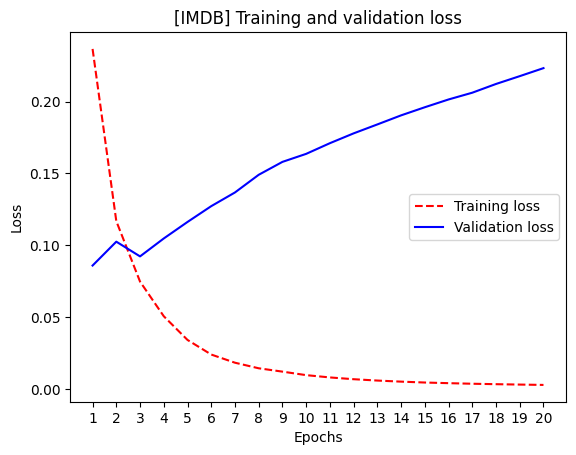

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("[IMDB] Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

**Interpreting the loss curves:** Training loss decreases every epoch (as expected with gradient descent). However, validation loss begins *increasing* after about epoch 4; this is classic **overfitting**. The model starts memorising training-specific patterns that don't generalise.

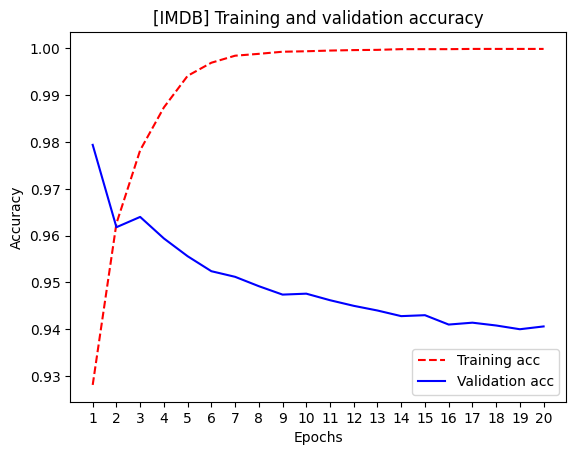

In [18]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("[IMDB] Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The accuracy curves tell the same story: training accuracy keeps climbing, but validation accuracy peaks around epoch 4 and then degrades. To prevent overfitting, we should stop training after ~4 epochs. (Next chpaters cover additional techniques for mitigating overfitting.)

In [19]:
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6955 - loss: 0.5999
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9051 - loss: 0.2796
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9338 - loss: 0.1936
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9496 - loss: 0.1511
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8807 - loss: 0.3003


We retrain from scratch for just 4 epochs (where validation performance peaked) and evaluate on the test set. This fairly naive approach typically achieves about **88% accuracy**. State-of-the-art approaches on this dataset can reach close to 95%.

In [20]:
results

[0.29976826906204224, 0.8824799656867981]

#### Using a trained model to generate predictions on new data

After training, you can call `model.predict()` to get the probability that each review is positive. Values near 1.0 indicate high confidence of a positive review; values near 0.0 indicate high confidence of a negative review. Values around 0.5 mean the model is uncertain.

In [21]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step  


array([[0.1448464 ],
       [0.99994457],
       [0.7187674 ],
       ...,
       [0.08911766],
       [0.05482459],
       [0.7068378 ]], dtype=float32)

#### Further experiments

Suggested experiments to build intuition:

- Try **1 or 3** intermediate layers instead of 2. How does it affect validation/test accuracy?
- Try layers with **32 or 64 units** instead of 16.
- Try `mean_squared_error` as the loss function instead of `binary_crossentropy`.
- Try `tanh` activation instead of `relu`.

#### Wrapping up

**Key takeaways from the binary classification example:**

- Raw data (sequences of words) must be preprocessed into tensors — multi-hot encoding is one option.
- Stacks of `Dense` layers with `relu` activations solve a wide range of problems.
- For binary classification, end with a single-unit `Dense` layer + `sigmoid` activation.
- Use `binary_crossentropy` as the loss function for sigmoid outputs.
- `adam` is a solid default optimiser.
- Neural networks eventually **overfit**; always monitor validation performance!

### Classifying newswires: A multiclass classification example

Now we move from binary to **multiclass classification**: classifying Reuters newswires into **46 mutually exclusive topics**. This is *single-label, multiclass classification*; each sample belongs to exactly one category.

(If each sample could belong to multiple categories, it would be *multilabel, multiclass classification*.)

#### The Reuters dataset

The Reuters dataset contains short newswires and their topics (published 1986). There are 46 different topics; some are more common than others, but each has at least 10 training examples. Like IMDb and MNIST, it's packaged with Keras. We again restrict to the top 10,000 words.

In [22]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
len(train_data)

8982

In [24]:
len(test_data)

2246

In [25]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [26]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[10]]
)

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


The indices are offset by 3 because indices 0, 1, and 2 are reserved for **"padding,"** **"start of sequence,"** and **"unknown"** respectively. These reserved indices have no entry in the word dictionary, so `dict.get(i - 3, "?")` falls back to the default `"?"` string. The `"?"` is just an arbitrary placeholder for display; you could use any string. This entire decoding step is purely for human inspection; the model only ever sees the integer sequences (and later, their multi-hot encoded form).

In [27]:
train_labels[10]

np.int64(3)

Each label is an integer between 0 and 45 — an index into the 46 topic categories.

#### Preparing the data

Input data is vectorised with the same multi-hot encoding as before.

For the **labels**, there are two options:
1. **One-hot (categorical) encoding** - each label becomes a 46-dimensional vector with a single 1.
2. **Integer encoding** - leave labels as integers and use a different loss function.

We'll show both approaches. Keras provides `to_categorical()` as a convenient built-in for one-hot encoding.

In [28]:
x_train = multi_hot_encode(train_data, num_tokens=10000)
x_test = multi_hot_encode(test_data, num_tokens=10000)

In [29]:
def one_hot_encode(labels, num_classes=46):
    results = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        results[i, label] = 1.0
    return results

y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)

In [30]:
from keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

#### Building your model

In [31]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)

The key difference from the binary case: we now have **46 output classes** instead of 2. This means:

- **Larger intermediate layers** (64 units instead of 16) - because a 16-dimensional space may be too limited to separate 46 classes. Small intermediate layers act as **information bottlenecks**, permanently dropping relevant information that later layers cannot recover.
- The final layer has **46 units** with a **`softmax` activation** - it outputs a probability distribution over all 46 classes (the 46 values sum to 1).
- The loss function is **`categorical_crossentropy`** - which measures the distance between the predicted probability distribution and the true label distribution.

We also track **top-3 accuracy** (`TopKCategoricalAccuracy`), which is a more nuanced metric than plain accuracy: it checks whether the correct class is among the model's top 3 predictions.

In [32]:
top_3_accuracy = keras.metrics.TopKCategoricalAccuracy(
    k=3, name="top_3_accuracy"
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", top_3_accuracy],
)

#### Validating your approach

We set aside 1,000 training samples as a validation set and train for 20 epochs.

In [33]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [34]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.3425 - loss: 3.5385 - top_3_accuracy: 0.4389 - val_accuracy: 0.5350 - val_loss: 2.5588 - val_top_3_accuracy: 0.6940
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5637 - loss: 2.2006 - top_3_accuracy: 0.7123 - val_accuracy: 0.6260 - val_loss: 1.6546 - val_top_3_accuracy: 0.7600
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6811 - loss: 1.4324 - top_3_accuracy: 0.7867 - val_accuracy: 0.7010 - val_loss: 1.3055 - val_top_3_accuracy: 0.8120
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7631 - loss: 1.0682 - top_3_accuracy: 0.8529 - val_accuracy: 0.7560 - val_loss: 1.1321 - val_top_3_accuracy: 0.8580
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8289 - loss: 0.8212 - top_3_accuracy: 0.9084 - val_accuracy: 0.7860 - val_loss: 1.0178 - val_top_3_accuracy: 0.8850
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8676 - loss: 0.6358 - top_3_a

We train for 20 epochs in mini-batches of 512, monitoring loss and accuracy on the held-out validation set at each epoch.

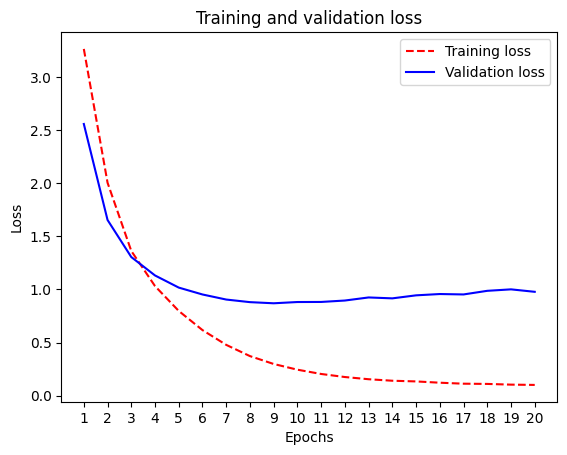

In [35]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

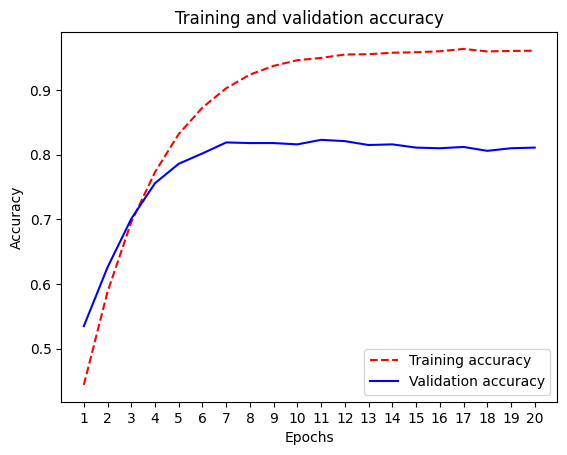

In [36]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

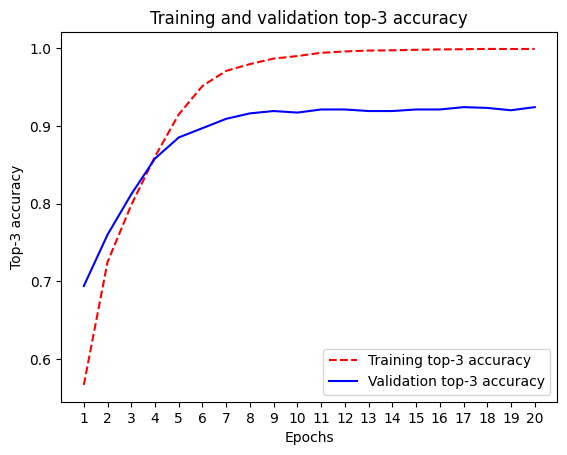

In [37]:
plt.clf()
acc = history.history["top_3_accuracy"]
val_acc = history.history["val_top_3_accuracy"]
plt.plot(epochs, acc, "r--", label="Training top-3 accuracy")
plt.plot(epochs, val_acc, "b", label="Validation top-3 accuracy")
plt.title("Training and validation top-3 accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Top-3 accuracy")
plt.legend()
plt.show()

In [38]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512,
)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.3408 - loss: 3.5808
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6156 - loss: 2.1474
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7123 - loss: 1.3634
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7692 - loss: 1.0500
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8217 - loss: 0.8250
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8712 - loss: 0.6227
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8987 - loss: 0.4745
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9158 - loss: 0.3914
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9329 - loss: 0.2964
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7998 - loss: 0.9118


The model begins overfitting after about 9 epochs, so we retrain from scratch for 9 epochs and evaluate on the test set. This reaches roughly **80% accuracy**.

In [39]:
results

[0.9323092699050903, 0.7965272068977356]

In [40]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels == test_labels_copy)
hits_array.mean()

np.float64(0.18121104185218165)

A random classifier scores about **19% accuracy** on this 46-class problem (due to class imbalance; it's not exactly 1/46 ≈ 2.2%). Our model's ~80% is a substantial improvement over this baseline.

#### Generating predictions on new data

Each prediction is a 46-dimensional vector, a probability distribution over all topics. The coefficients sum to 1. The predicted class is the one with the highest probability (`np.argmax`).

In [41]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [42]:
predictions[0].shape

(46,)

In [43]:
np.sum(predictions[0])

np.float32(0.9999999)

In [44]:
np.argmax(predictions[0])

np.int64(3)

#### A different way to handle the labels and the loss

Instead of one-hot encoding the labels, you can leave them as integers and switch the loss to `sparse_categorical_crossentropy`. This is mathematically identical to `categorical_crossentropy`, just with a different interface that accepts integer labels directly.

In [45]:
y_train = train_labels
y_test = test_labels

In [46]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

#### The importance of having sufficiently large intermediate layers

What happens when an intermediate layer is much smaller than the number of output classes? Here we test a layer with only **4 units** trying to feed into 46 output classes, a severe **information bottleneck**. The model tries to compress all the information needed to separate 46 classes into just 4 dimensions, and inevitably loses critical information.

In [47]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val),
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1763 - loss: 3.4955 - val_accuracy: 0.2580 - val_loss: 2.7153
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2621 - loss: 2.5184 - val_accuracy: 0.2930 - val_loss: 1.9236
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4359 - loss: 1.6580 - val_accuracy: 0.6730 - val_loss: 1.4380
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7146 - loss: 1.1881 - val_accuracy: 0.6950 - val_loss: 1.3029
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7630 - loss: 0.9661 - val_accuracy: 0.7000 - val_loss: 1.2842
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7979 - loss: 0.8500 - val_accuracy: 0.7120 - val_loss: 1.2708
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8232 - loss: 0.7386 - val_accuracy: 0.7130 - val_loss: 1.3054
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8377 - loss: 0.6718 - val_accuracy: 0.7100 - val_loss

The bottleneck model peaks at roughly **71% validation accuracy**, which is about 8 percentage points worse than the 64-unit version. The lesson: avoid intermediate layers that are significantly smaller than your number of output classes (unless you have a reason to do so).

#### Further experiments

Suggested experiments to build intuition:

- Try **1 or 3** intermediate layers instead of 2. How does it affect validation/test accuracy?
- Try layers with **32 or 64 units** instead of 16.
- Try `mean_squared_error` as the loss function instead of `binary_crossentropy`.
- Try `tanh` activation instead of `relu`.

#### Wrapping up

**Key takeaways from the multiclass classification example:**

- For *N* output classes, end with a `Dense` layer of size *N*.
- Use `softmax` activation for single-label multiclass problems (outputs a probability distribution).
- Use `categorical_crossentropy` (with one-hot labels) or `sparse_categorical_crossentropy` (with integer labels).
- Don't create information bottlenecks; keep intermediate layers at least as wide as the number of output classes.

### Predicting house prices: A regression example

Now we tackle **scalar regression** - predicting a single continuous value instead of a discrete label. We'll predict median home prices in California districts using census data.

> *Note:* Despite the name, **logistic regression** is actually a classification algorithm, not regression.

#### The California Housing Price dataset

The dataset contains information about California districts from the 1990 census. We use the **"small" version** with 600 districts (real-world datasets are often tiny). Each district has 8 features: longitude, latitude, median house age, population, number of households, median income, total rooms, and total bedrooms. The target is the median home value in dollars.

In [48]:
from keras.datasets import california_housing

(train_data, train_targets), (test_data, test_targets) = (
    california_housing.load_data(version="small")
)

743530/743530 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [49]:
train_data.shape

(480, 8)

In [50]:
test_data.shape

(120, 8)

In [51]:
train_targets

array([228400., 132900.,  60000.,  95200., 107000., 122500., 132000.,
       290100., 257800., 390100., 220800., 284900.,  97500., 415300.,
        84200., 185600., 216700., 233100., 127000., 182300.,  92300.,
        90700., 102100., 112500., 350700., 156500., 220700., 147400.,
       216700., 275000., 198200., 119100., 289500., 152500., 125000.,
       104500.,  93800.,  89300., 452600., 128600., 311500.,  90000.,
       218200., 131300.,  67500., 139400., 500001., 182600., 111300.,
       112500., 134700.,  71300., 207400., 331400., 107900.,  87500.,
       342200.,  87100., 314700., 368600., 211600., 338900., 366100.,
       164300.,  91700., 261400., 218500., 155400., 273700.,  81800.,
       138800.,  99700., 156300., 140600., 152700., 108900., 351200.,
       126000., 137500., 196900., 240000., 172800., 254200.,  97500.,
       182700., 162500.,  86100., 226700., 412500., 165900., 327100.,
       162500., 188800., 183800.,  90600., 372000., 275000., 151800.,
       125000., 1291

Prices range from about \$60,000 to \$500,000 (remember: 1990 dollars, not inflation-adjusted).

#### Preparing the data

**Feature-wise normalisation** is crucial when features have wildly different ranges. For each feature, subtract the mean and divide by the standard deviation, centering each feature around 0 with unit variance.

**Important:** The normalisation statistics (mean, std) must be computed from the *training data only* - never use quantities derived from the test data.

We also **scale the targets** by dividing by 100,000. Since model weights start small and inputs are normalised near 0, initial predictions will also be small. If targets are in the 60,000-500,000 range, the model would need very large weights to match, which would slow down learning considerably.

In [52]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

In [53]:
y_train = train_targets / 100000
y_test = test_targets / 100000

#### Building your model

With so few samples (480 training), we use a **very small model** to mitigate overfitting: two intermediate layers with 64 units each.

Key differences from classification:

- The final layer has **1 unit with no activation** (purely linear) - this is standard for scalar regression. An activation function like sigmoid would constrain the output to `[0, 1]`, but we need the model to be free to predict values in any range.
- The **loss function** is `mean_squared_error` (MSE) - the squared difference between predictions and targets, widely used for regression.
- We monitor **mean absolute error** (MAE) - a more interpretable metric. An MAE of 0.5 means predictions are off by $50,000 on average (given our target scaling of ÷100,000).

The model is wrapped in a `get_model()` function because we'll need to instantiate fresh models multiple times for K-fold validation.

In [54]:
def get_model():
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model

#### Validating your approach using K-fold validation

With so few data points, a simple train/validation split would yield a tiny validation set (~100 samples), making validation scores highly variable; they'd fluctuate depending on which samples happened to land in the validation set.

**K-fold cross-validation** solves this by:
1. Splitting data into *K* partitions (we use K=4)
2. Training *K* separate models — each uses K-1 partitions for training and the remaining 1 for validation
3. Averaging the K validation scores for a more reliable estimate

This is the standard approach when working with limited data.

In [55]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 50
all_scores = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    model.fit(
        fold_x_train,
        fold_y_train,
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores
    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [56]:
[round(value, 3) for value in all_scores]

[0.31, 0.293, 0.251, 0.307]

In [57]:
round(np.mean(all_scores), 3)

np.float64(0.29)

The individual fold scores vary meaningfully (e.g. from ~0.23 to ~0.35), but the **average** gives a much more reliable estimate; that's the whole point of K-fold validation. An MAE of ~0.30 means we're off by about \$30,000 on average, which is significant for prices in the \$60K-\$500K range.

In [58]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


Training for 200 epochs and recording the validation MAE at each epoch lets us find the optimal training duration.

In [59]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

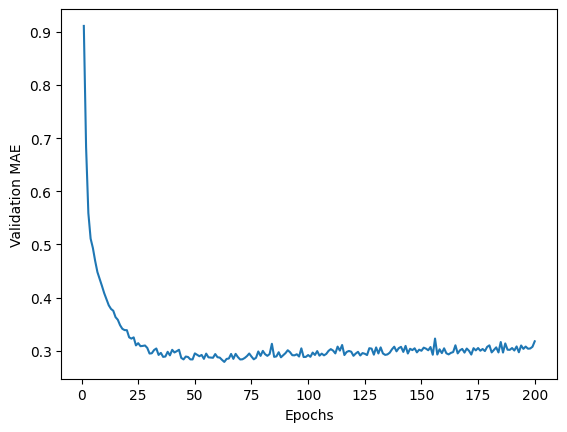

In [60]:
epochs = range(1, len(average_mae_history) + 1)
plt.plot(epochs, average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

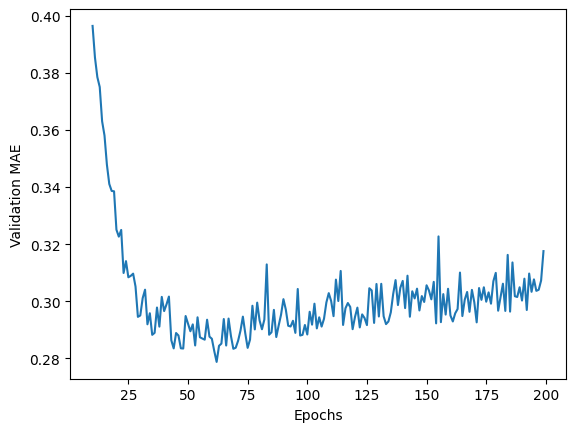

In [61]:
truncated_mae_history = average_mae_history[10:]
epochs = range(10, len(truncated_mae_history) + 10)
plt.plot(epochs, truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

After omitting the first 10 epochs (which are on a different scale), we can see that validation MAE stops improving significantly after about **120-140 epochs**. Beyond that point, the model starts overfitting.

In [62]:
model = get_model()
model.fit(x_train, y_train, epochs=130, batch_size=16, verbose=0)
test_mean_squared_error, test_mean_absolute_error = model.evaluate(
    x_test, y_test
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2829 - mean_absolute_error: 0.3227


We train the final production model on **all** training data for 130 epochs (the sweet spot identified from our K-fold analysis) and evaluate on the held-out test set.

In [63]:
round(test_mean_absolute_error, 3)

0.309

A test MAE of ~0.31 means our predictions are off by about **$31,000** on average.

#### Generating predictions on new data

In [64]:
predictions = model.predict(x_test)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([2.5702834], dtype=float32)